In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm

from src.data import DataLoader
from src.helpers import (
    calculate_ats_performance,
    calculate_seasonal_accuracy,
    calculate_spread_percentile,
    load_all_predictions,
)
from src.paths import PREDICTION_DIR

# Data

In [2]:
game_data = DataLoader(2020, 2025).data

prediction_data = load_all_predictions(PREDICTION_DIR)

data = pd.merge(
    game_data,
    prediction_data,
    on=["season", "week", "home_team", "away_team"],
    how="inner",
).dropna(subset=["result"])

# Methodology

Each row of the data represents a historical game and contains the following features:
- Season
- Week
- Home Team
- Away Team
- Closing / Opening Spread (positive means the home team was favored)
- Game Result (home team score - away team score)
- Model Predictions (model generated percentiles of the predicted score differential distribution)

For each game we identify where the spread falls within the model's predicted distribution. This is done by finding the percentile index (*spread_idx*) such that:

$$
spread\_idx = P(\text{Predicted Score Differential} \leq \text{Spread})
$$

Intuitively:
- A *spread_idx* near **50** means the spread closely matches the model's expectation.
- A *spread_idx* near **0** or **100** means the spread is far from what the model predicts--suggesting a potential market inefficiency.

The following figure illustrates this concept. The blue curve represents the model's predicted distribution of score differentials, and the dashed red line shows where the actual spread lies within that distribution.

In this example, the spread lies far to the right of the model’s expected distribution (*spread_idx = 84*). This indicates that the market may be overestimating the home team’s advantage, and the model would favor a bet on the away team.

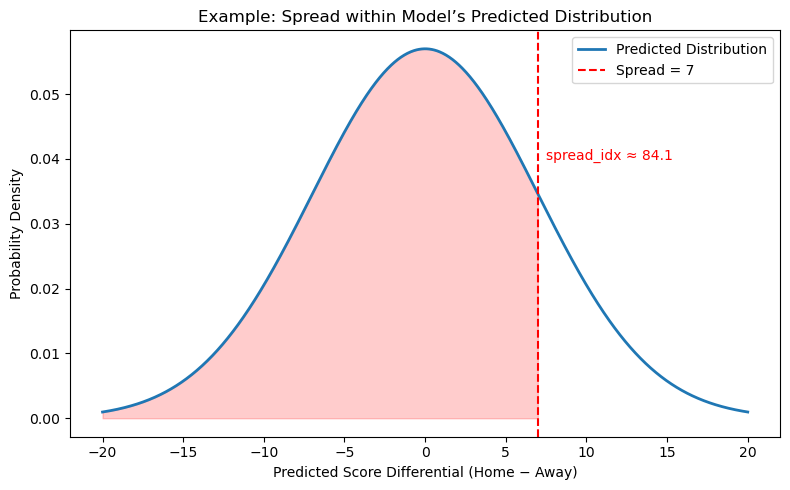

In [3]:
x = np.linspace(-20, 20, 1000)
mean, std = 0, 7
pdf = norm.pdf(x, mean, std)
spread = 7

plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label="Predicted Distribution", lw=2)
plt.axvline(
    spread,
    color="red",
    linestyle="--",
    label=f"Spread = {spread}",
)
plt.fill_between(x, 0, pdf, where=(x <= spread), color="red", alpha=0.2)
percentile = norm.cdf(spread, mean, std) * 100
plt.text(spread + 0.5, max(pdf) * 0.7, f"spread_idx ≈ {percentile:.1f}", color="red")
plt.title("Example: Spread within Model’s Predicted Distribution")
plt.xlabel("Predicted Score Differential (Home − Away)")
plt.ylabel("Probability Density")
plt.legend()
plt.tight_layout()
plt.show()

To express the *spread_idx* in a simple, human-understandable way, we define:

$$
confidence = \frac{|spread\_idx - 50|}{50}
$$

Values range from **0 (uncertain)** to **1 (confident)**. For example, a *spread_idx* of 80 or 20 would yield a confidence of 0.6 (or 60% confident). This metric allows us to summarize how "sure" the model is about each prediction while maintaining intuitive interpretability.

To test whether this confidence translates into practical value, we simulate a simple betting strategy:

- Define a **minimum confidence threshold** (e.g., 0.5, 0.6, 0.7). Only games where the model's confidence exceeds this threshold are considered for betting.
- For each qualifying game:
  - Bet on the **away team** if `spread_idx > 50`
  - Bet on the **home team** if `spread_idx < 50`
- Determine wins and losses by comparing the actual game result to the spread in the predicted direction.

By iterating through a range of confidence thresholds, we measure:
- **Bets Placed** – Number of games meeting the confidence cutoff
- **Bets Won** – Number of correct predictions among those bets
- **Accuracy** – `Bets Won / Bets Placed`

# Results

In [4]:
# Store spread_idx and confidence
for line, spread_col in [("close", "spread_line"), ("open", "spread_line_open")]:
    data[f"spread_idx_{line}"] = data.apply(
        lambda row: (
            calculate_spread_percentile(row, spread_col)
            if pd.notna(row[spread_col])
            else np.nan
        ),
        axis=1,
    )
    data[f"confidence_{line}"] = (data[f"spread_idx_{line}"] - 50).abs() / 50

# Simulation results
results = {}

all_seasons = list(data["season"].unique())
confidence_thresholds = np.linspace(0, 1, 101)

for threshold in tqdm(confidence_thresholds):
    out_df = calculate_ats_performance(data, threshold)
    out_df = calculate_seasonal_accuracy(out_df).set_index("season")
    results[threshold] = {}

    for season in ["overall"] + all_seasons:
        results[threshold][season] = {
            "bets_placed_close": out_df.loc[season, "bets_placed_close"],
            "bets_won_close": out_df.loc[season, "bets_won_close"],
            "bets_placed_open": out_df.loc[season, "bets_placed_open"],
            "bets_won_open": out_df.loc[season, "bets_won_open"],
            "accuracy_close": out_df.loc[season, "accuracy_close"],
            "accuracy_open": out_df.loc[season, "accuracy_open"],
        }

100%|██████████| 101/101 [00:46<00:00,  2.18it/s]


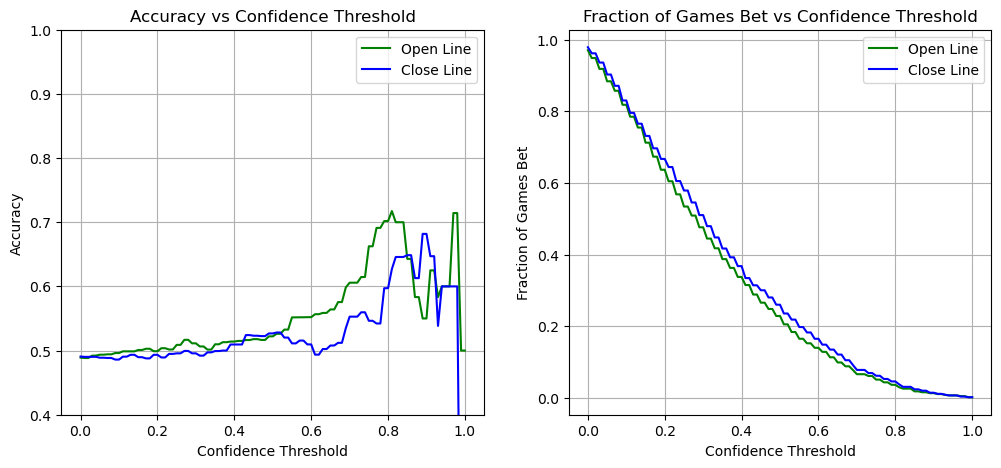

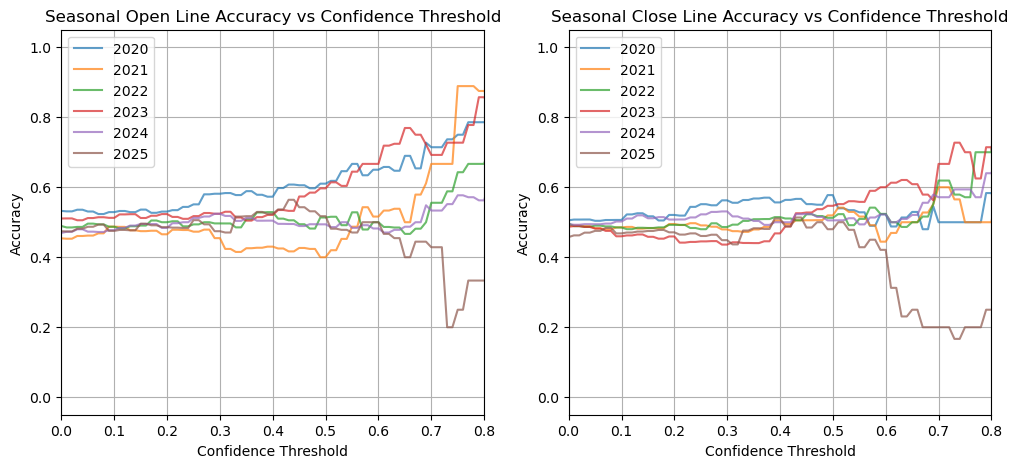

In [5]:
# Figures 1 & 2: Accuracy vs Confidence & Fraction of Bets vs Confidence
conf_thresh = list(results.keys())
open_accuracy = [i["overall"]["accuracy_open"] for i in results.values()]
close_accuracy = [i["overall"]["accuracy_close"] for i in results.values()]
open_bet_pctg = [i["overall"]["bets_placed_open"] / len(data) for i in results.values()]
close_bet_pctg = [
    i["overall"]["bets_placed_close"] / len(data) for i in results.values()
]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(conf_thresh, open_accuracy, color="green", label="Open Line")
plt.plot(conf_thresh, close_accuracy, color="blue", label="Close Line")
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Confidence Threshold")
plt.grid(True)
plt.ylim(0.4, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(conf_thresh, open_bet_pctg, color="green", label="Open Line")
plt.plot(conf_thresh, close_bet_pctg, color="blue", label="Close Line")
plt.xlabel("Confidence Threshold")
plt.ylabel("Fraction of Games Bet")
plt.title("Fraction of Games Bet vs Confidence Threshold")
plt.grid(True)
plt.legend()

plt.show()

# Figure 2 & 3: Seasonal Open & Close Line Accuracy

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for season in all_seasons:
    open_accuracy_season = [i[season]["accuracy_open"] for i in results.values()]
    plt.plot(conf_thresh, open_accuracy_season, label=f"{season}", alpha=0.7)
plt.xlim(0.0, 0.8)
plt.grid(True)
plt.legend()
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Seasonal Open Line Accuracy vs Confidence Threshold")

plt.subplot(1, 2, 2)
for season in all_seasons:
    close_accuracy_season = [i[season]["accuracy_close"] for i in results.values()]
    plt.plot(conf_thresh, close_accuracy_season, label=f"{season}", alpha=0.7)
plt.xlim(0.0, 0.8)
plt.grid(True)
plt.legend()
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Seasonal Close Line Accuracy vs Confidence Threshold")

plt.show()

As seen in the figures above, the model shows signal, especially in high confidence games against the opening spread. While the overall trend shows higher confidence levels correspond to higher accuracy, individual seasons often deviate from this pattern. This seasonal variation might be expected due to the probabilistic nature of sports outcomes. Even if the model has a true winning probability of **p=55%**, a limited number of bets in a single season can produce apparent underperformance purely by chance.

We can formalize this using the binomial distribution. Let **n** be the number of bets placed in a season (for example, around 36 bets per season at a 60% confidence level with the opening spread), and let **W ~ Binomial(n, p)** represent the number of wins. 

The probability of a losing season (winning fewer than half of the bets) is:

$$
P(W < 18) = \sum_{k=0}^{17} \binom{36}{k} 0.55^k \cdot 0.45^{36-k} = 0.22
$$

So far 2025 has been an outlier in low overall performance. This could be a sign of model weakness, or just a limited number of bets so far--but only time will tell.